In [1]:
cd ..\..

C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D


In [2]:
import sys
import numpy as np
import json
import torch

from Magnetisation.Propagator import Propagator
from Magnetisation.Generator import generator_CNN
from Magnetisation.Train import Magnetisation_CNN_training
from Magnetisation.Evaluate import evaluate

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
#from tqdm import tqdm
# unit_conversion = 1e-18 / 9.27e-24


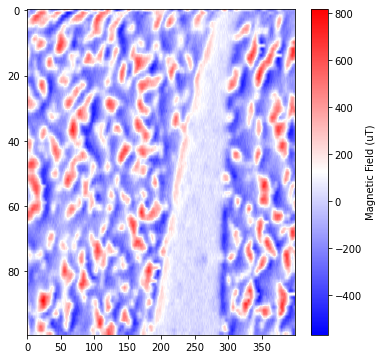

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Extract the data
filename = 'data/Magnetisation out of plane/MoirePatten_Stuttgart.lvm'


lvm = np.loadtxt(filename).reshape(100,800)


Xdata = np.linspace(0,3000,400)
Ydata = np.linspace(0,3000,100)

MagneticField = 1e-6 *lvm[::,0:400] / (2.8e4)
fft_signal = np.fft.fft2(MagneticField) 
fft_signal_clean = np.where(fft_signal.imag==0,0,fft_signal)
MagneticField = np.fft.ifft2(fft_signal_clean).real


fig = plt.figure()
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(6)
# set width of each subplot as 8
fig.set_figwidth(6)
#PROP.MagneticFieldExtended = np.where(np.abs(PROP.MagneticFieldExtended) <(PROP.MagneticFieldExtended.mean()+PROP.MagneticFieldExtended.std()), 0, PROP.MagneticFieldExtended)

plt.imshow(1e6*MagneticField, cmap="bwr", aspect="auto")
plt.colorbar(label="Magnetic Field (uT)")
#plt.clim([-20, 20])




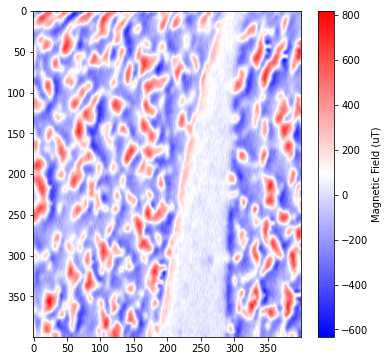

In [4]:
# interp the data
from scipy import interpolate

x = np.arange(0, 3000, 3000/400)
y = np.arange(0, 3000, 3000/100)

xnew = np.arange(0, 3000, 3000/400)
ynew = np.arange(0, 3000, 3000/400)

xx, yy = np.meshgrid(x, y)
f = interpolate.interp2d(x, y, MagneticField, kind='cubic')
MagnetInterp = f(xnew, ynew)

fig = plt.figure()
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(6)
# set width of each subplot as 8
fig.set_figwidth(6)
#PROP.MagneticFieldExtended = np.where(np.abs(PROP.MagneticFieldExtended) <(PROP.MagneticFieldExtended.mean()+PROP.MagneticFieldExtended.std()), 0, PROP.MagneticFieldExtended)

plt.imshow(1e6* MagnetInterp, cmap="bwr", aspect="auto")
plt.colorbar(label="Magnetic Field (uT)")

[[-6.49958950e-05  7.30685488e-05 -6.49958950e-05 ... -1.57540432e-04
  -1.39360678e-04 -1.01806059e-04]
 [-2.30246474e-05  4.70263707e-05 -5.19484799e-05 ... -1.58623110e-04
  -1.74137130e-04 -1.09232592e-04]
 [-9.66033471e-06  1.03971139e-05 -4.91661631e-05 ... -1.58308233e-04
  -1.88445784e-04 -1.15801913e-04]
 ...
 [ 2.66774950e-04  1.83400508e-04  1.41584367e-04 ... -3.61839196e-04
  -3.83034691e-04 -2.95337526e-04]
 [ 2.66774950e-04  1.83400508e-04  1.41584367e-04 ... -3.61839196e-04
  -3.83034691e-04 -2.95337526e-04]
 [ 2.66774950e-04  1.83400508e-04  1.41584367e-04 ... -3.61839196e-04
  -3.83034691e-04 -2.95337526e-04]]


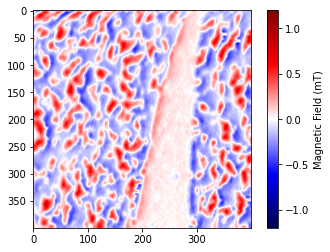

In [5]:
MagneticField = MagnetInterp

PropagationOptions = dict() 
PropagationOptions['PixelSize'] = (3000e-9)/400 
PropagationOptions['PixelSizeY'] = (3000e-9)/400 
PropagationOptions['ImageShape'] = 512 
PropagationOptions['NV'] = dict() 
PropagationOptions['NV']['FindTheta']= False 
PropagationOptions['NV']['Theta'] = 53 
PropagationOptions['NV']['FindPhi']= False 
PropagationOptions['NV']['Phi'] = 282 
PropagationOptions['NV']['Height'] = 50e-9 
PropagationOptions['Magnetisation'] = dict() 
PropagationOptions['Magnetisation']['FindTheta']=False 
PropagationOptions['Magnetisation']['Theta'] = 0 
PropagationOptions['Magnetisation']['FindPhi']= False 
PropagationOptions['Magnetisation']['Phi'] = 0 
PropagationOptions['FFT'] = dict() 
PropagationOptions["FFT"]["PaddingFactor"]= 2 
PropagationOptions["FFT"]["performPadding"]= False 
PropagationOptions["FFT"]["PaddingMode"] = 'constant' 
PropagationOptions['FFT']['Extended'] = False 
PropagationOptions['FFT']['Extention'] = 100 
PropagationOptions['FFT']['Filter'] = dict() 
PropagationOptions['FFT']['Filter']['useHanning'] = False 
PropagationOptions['FFT']['Filter']['useHighCutoff'] = False 
PropagationOptions['FFT']['Filter']['useLowCutoff'] = False 
PropagationOptions['FFT']['Filter']['LambdaHighCutoff'] = 100e-9 
PropagationOptions['FFT']['Filter']['LambdaLowCutoff'] = 7e-06

PROP = Propagator(PropagationOptions, MagneticField,PropagationOptions['ImageShape'])
# Extend the data set to the requested square dimensions
# Returns to self.MagneticFieldExtended


plt.imshow(1e3*MagneticField, cmap="seismic",vmin = -1.2, vmax = 1.2) 
plt.colorbar(label="Magnetic Field (mT)") #plt.clim([-20, 20])

In [6]:
Generator = generator_CNN(Size=1, ImageSize=PropagationOptions['ImageShape']).to(device)

In [7]:
ML_options = dict()
ML_options['mlp']=False
ML_options['LossFunction'] = 'L1'
ML_options['Epochs'] = 50
ML_options['Magnetization'] = None 
ML_options['PositiveMagnetisationOnly'] = False
ML_options['PrintLossValue'] = False
ML_options['IntegerOnly'] = False

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D\Magnetisation\Propagator.py:356: RuntimeWarning: invalid value encountered in true_divide
  [-(kx ** 2) / k, -(kx * ky) / k, -1j * kx],
C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D\Magnetisation\Propagator.py:357: RuntimeWarning: invalid value encountered in true_divide
  [-kx * ky / k, -(ky ** 2 / k), -1j * ky],
C:\Users\parax\anaconda3\envs\py_new\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:244.)
  Variable._execution_engine.run_backward(
100%|██████████| 50/50 [00:36<00:00,  1.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose 

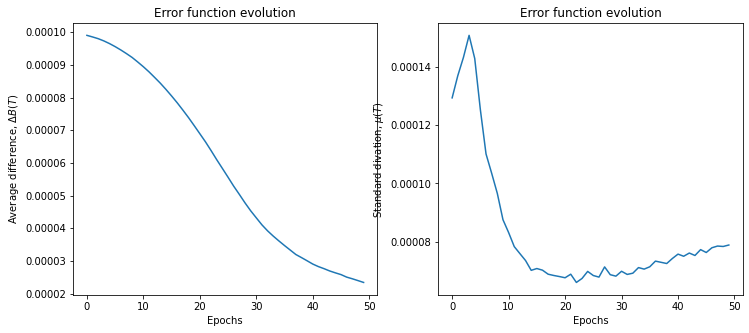

In [8]:
# Train the network
CNN_training = Magnetisation_CNN_training(device, Generator, PROP, ML_options)
bnv_cnn = CNN_training.train_cnn(**ML_options)

In [9]:
means,stds,pred,ci_upper,ci_lower, ic_acc,ic_acc2,loss = CNN_training.evaluateCNN()

C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D\Magnetisation\Train.py:274: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Results["Original B"] = np.rot90(self.PROP.MagneticFieldExtended[self.PROP.OriginalROI] * unit_conversion_M_to_B, k=1)
C:\Users\parax\Dropbox\Programming\Python\magnetisation_reconstruction\2D\Magnetisation\Train.py:275: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Results["Reconstructed B"] = np.rot90(ReconstructedBnv[self.PROP.OriginalROI] * unit_conversion_M_to_B , k=1)
C:\Users\parax\Drop

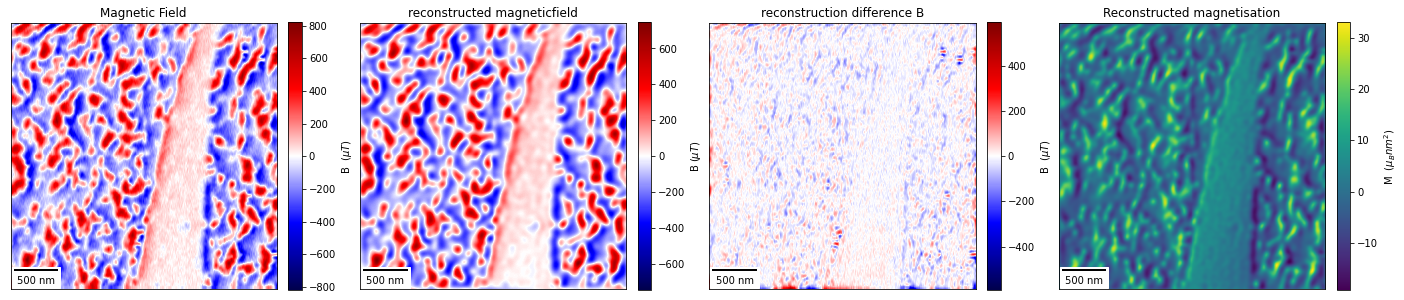

In [10]:
Results = CNN_training.extract_results(plotResults = True)

In [11]:
OriginalMagneticField = np.flipud(Results['Original B'])[2:-2,2:-2]
Bnv_NN = np.flipud(Results['Reconstructed B'])[2:-2,2:-2]
Magnetisation_NN = np.flipud(Results['Magnetisation'])[2:-2,2:-2]

32.990345

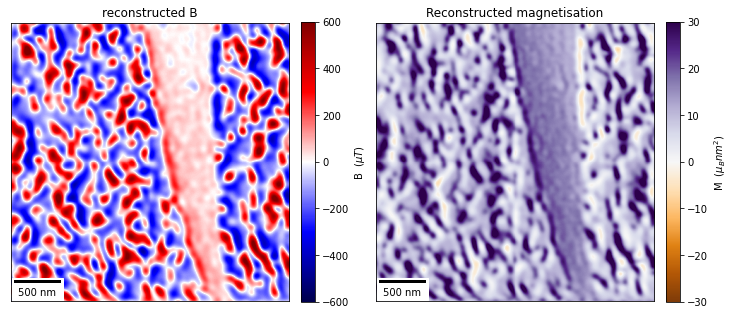

In [12]:
fig = plt.figure()
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(6)
# set width of each subplot as 8
fig.set_figwidth(12)

ax3 = plt.subplot(1,2,1)
plt.imshow(1e6*Bnv_NN,cmap='seismic')
scalebar = ScaleBar(PropagationOptions['PixelSize'], location='lower left')
ax3.add_artist(scalebar)
plt.xticks([])
plt.yticks([])
plt.colorbar(fraction=0.046, pad=0.04,label="B  ($\mu T)$")
plt.clim([-600,600])
plt.title('reconstructed B')

ax4 = plt.subplot(1,2,2)
plt.imshow(Magnetisation_NN + 12,cmap='PuOr')
scalebar = ScaleBar(PropagationOptions['PixelSize'], location='lower left')
ax4.add_artist(scalebar)
plt.xticks([])
plt.yticks([])
plt.colorbar(fraction=0.046, pad=0.04,label="M  ($\mu_B nm^2$)")
plt.clim([-30,30])
plt.title('Reconstructed magnetisation')

display(np.max(Magnetisation_NN))

In [13]:
from Magnetisation.utils import SaveDictToJson
# SaveDictToJson("Results/ML_Reconstruction_Moire_Pattern", Results)

serialize NumPy array into JSON and write into a file


FileNotFoundError: [Errno 2] No such file or directory: 'Results/ML_Reconstruction_Moire_Pattern.json'